In [5]:
# !wget http://download.tensorflow.org/example_images/flower_photos.tgz
# !tar -xvf "flower_photos.tgz"

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext

In [2]:
spark = SparkSession.builder \
        .appName('Pyspark-Flower-Classification') \
        .getOrCreate()
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
import pandas as pd
from PIL import Image
import numpy as np
import io
import seaborn as sns
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

from pyspark.sql.types import *
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, split, reverse, udf
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, VectorIndexer, StringIndexer
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml import Pipeline
from pyspark.ml.classification import MultilayerPerceptronClassifier, NaiveBayes, LogisticRegression

2021-10-18 17:57:13.181372: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-18 17:57:13.181422: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
# loaded image
df = spark.read.format("binaryFile")\
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load('flower_photos')

In [5]:
df.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)



In [6]:
df = df.withColumn('label', reverse(split(df['path'], '/')).getItem(1))
df.toPandas().head()

,path,modificationTime,length,content,label
0,hdfs://cluster-a894-m/user/root/flower_photos/...,2021-10-18 15:11:15.496,281953,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",tulips
1,hdfs://cluster-a894-m/user/root/flower_photos/...,2021-10-18 15:10:53.565,277326,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",sunflowers
2,hdfs://cluster-a894-m/user/root/flower_photos/...,2021-10-18 15:11:25.105,265806,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",tulips
3,hdfs://cluster-a894-m/user/root/flower_photos/...,2021-10-18 15:10:49.926,257418,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",sunflowers
4,hdfs://cluster-a894-m/user/root/flower_photos/...,2021-10-18 15:12:11.802,248540,"[255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...",daisy


In [7]:
model = EfficientNetB0(include_top=False)
# model.summary()

2021-10-18 17:57:35.237685: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-18 17:57:35.237730: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-18 17:57:35.237763: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cluster-a894-m): /proc/driver/nvidia/version does not exist
2021-10-18 17:57:35.238025: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
bc_model_weights = spark.sparkContext.broadcast(model.get_weights())

def model_fn():
    """
    Returns a Efficient Net B0 model with top layer removed and broadcasted pretrained weights.
    """
    model = EfficientNetB0(weights=None, include_top=False)
    model.set_weights(bc_model_weights.value)
    return model

In [9]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

In [10]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/usr/lib/spark/python/pyspark/sql/pandas/functions.py:389: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [11]:
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

In [12]:
features_df = df.repartition(16).select(col("path"), featurize_udf("content").alias("features"), col('label'))
features_df.show(5)

+--------------------+--------------------+----------+
|                path|            features|     label|
+--------------------+--------------------+----------+
|hdfs://cluster-a8...|[-0.24996313, 0.0...|    tulips|
|hdfs://cluster-a8...|[-0.117673256, -0...| dandelion|
|hdfs://cluster-a8...|[-0.2778819, -0.1...|sunflowers|
|hdfs://cluster-a8...|[-0.08019082, -0....|     daisy|
|hdfs://cluster-a8...|[-0.17554493, -0....|    tulips|
+--------------------+--------------------+----------+
only showing top 5 rows



In [13]:
# MLLib post processing for features column formatting
list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
features_df = features_df.select(
   col("path"),  
   list_to_vector_udf(features_df["features"]).alias("features"),
   col("label")
)

In [14]:
# split train/valid/test set
train_df, test_df =  features_df.randomSplit([0.8, 0.2], 42)  

In [15]:
# concatenates all features into a single feature vector
vectorAssembler = VectorAssembler(inputCols=['features'], outputCol="featuresModel")

# add the labels through String Indexer
labelIndexer = StringIndexer(inputCol="label", outputCol="indexLabel").fit(features_df)

###  LogisticRegression

In [16]:
# define Classifier
lr = LogisticRegression(maxIter=5, 
    regParam=0.03, 
    elasticNetParam=0.5, 
    labelCol="indexLabel", 
    featuresCol="featuresModel"
    )

In [17]:
%%time
# define Pipeline
pipeline = Pipeline(stages=[labelIndexer, vectorAssembler, lr])
lrmodel = pipeline.fit(train_df)

21/10/18 16:19:29 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.5 MiB
21/10/18 16:24:43 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.5 MiB
21/10/18 16:24:44 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.5 MiB
21/10/18 16:29:53 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.5 MiB
21/10/18 16:29:53 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/10/18 16:29:53 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
21/10/18 16:29:54 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.5 MiB
21/10/18 16:29:58 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.5 MiB
21/10/18 16:29:59 WARN org.apache.spark.scheduler.DAGSchedule

In [20]:
# evaluating the model and show results
pred = lrmodel.transform(test_df)
pred.select("prediction", "indexLabel", "features").show(5)

21/10/18 16:31:30 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.2 MiB


+----------+----------+--------------------+
|prediction|indexLabel|            features|
+----------+----------+--------------------+
|       4.0|       4.0|[-0.1635916978120...|
|       4.0|       4.0|[-0.1055607572197...|
|       4.0|       4.0|[-0.2619636654853...|
|       4.0|       4.0|[-0.2633413076400...|
|       4.0|       4.0|[-0.2042101025581...|
+----------+----------+--------------------+
only showing top 5 rows



In [ ]:
# LR - compare prediction and GT and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="indexLabel", predictionCol="prediction")

print('F1-Score ', evaluator.evaluate(pred, {evaluator.metricName:'f1'}))
print('Precision ', evaluator.evaluate(pred, {evaluator.metricName: 'weightedPrecision'}))
print('Recall ', evaluator.evaluate(pred, {evaluator.metricName: 'weightedRecall'}))
print('Accuracy ', evaluator.evaluate(pred, {evaluator.metricName: 'accuracy'}))

21/10/18 16:31:57 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.2 MiB


F1-Score  0.8645305904080929


21/10/18 16:36:32 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.2 MiB


Precision  0.8669180934094906


21/10/18 16:41:08 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.2 MiB


Recall  0.8637602179836512


21/10/18 16:45:45 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.2 MiB


Accuracy  0.8637602179836512


In [61]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.GnBu):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

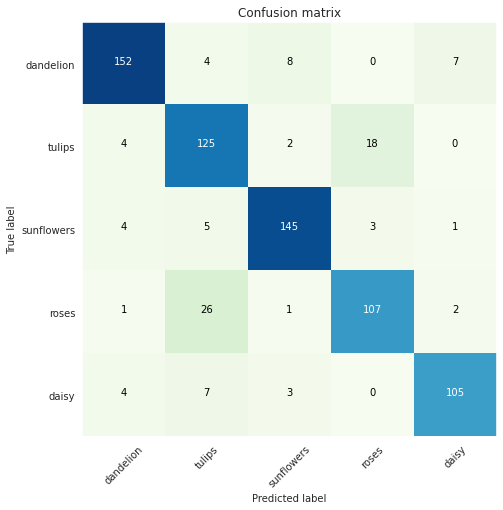

In [62]:
# Logistic Regression - Confusion Matrix

y_true = pred.select("indexLabel").toPandas()
y_pred = pred.select("prediction").toPandas()
cnf_matrix = confusion_matrix(y_true, y_pred, labels=range(5))

%matplotlib inline
sns.set_style("darkgrid")
plt.figure(figsize=(7,7))
plt.grid(False)
plot_confusion_matrix(cnf_matrix, classes=['dandelion','tulips', 'sunflowers', 'roses', 'daisy'])